In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv")
orange_cap = pd.read_csv("orange_cap.csv")
purple_cap = pd.read_csv("purple_cap.csv")
teams_data = pd.read_csv("teams_data.csv")
players_data = pd.read_csv("players-data-updated.csv")
matches_2025 = pd.read_csv("ipl_2025_matches_data.csv")

datasets_info = {
    "Deliveries": deliveries.shape,
    "Matches": matches.shape,
    "Orange Cap": orange_cap.shape,
    "Purple Cap": purple_cap.shape,
    "Teams Data": teams_data.shape,
    "Players Data": players_data.shape,
    "Matches 2025": matches_2025.shape
}

datasets_info

{'Deliveries': (17183, 19),
 'Matches': (74, 22),
 'Orange Cap': (15, 16),
 'Purple Cap': (15, 14),
 'Teams Data': (16, 2),
 'Players Data': (772, 6),
 'Matches 2025': (74, 23)}

In [5]:
def safe_parse_date_col(df, col):
    try:
        df[col+"_dt"] = pd.to_datetime(df[col], errors='coerce')
    except Exception as e:
        df[col+"_dt"] = pd.NaT
    return df

matches = safe_parse_date_col(matches, "date")
deliveries = safe_parse_date_col(deliveries, "date")
matches_2025 = safe_parse_date_col(matches_2025, "date")

C:\Users\hitar\AppData\Local\Temp\ipykernel_16640\983356530.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col+"_dt"] = pd.to_datetime(df[col], errors='coerce')



--- Match winners summary ---

match_winner
PBKS    11
RCB     10
GT       9
MI       8
DC       8
SRH      6
LSG      6
KKR      5
CSK      4
RR       4
Name: count, dtype: int64


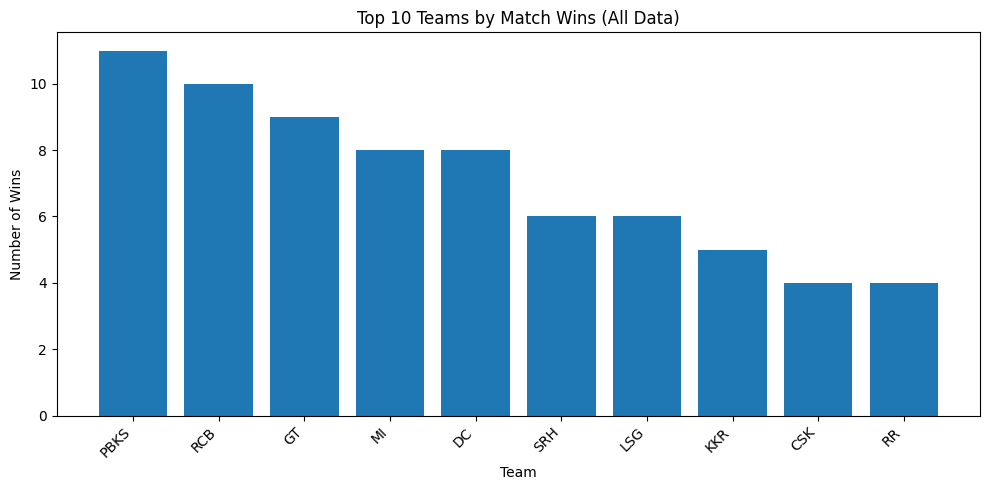

In [6]:
print("\n--- Match winners summary ---\n")
win_counts = matches['match_winner'].value_counts(dropna=True)
print(win_counts.head(12))

# Plot top teams by wins
top_n = 10
top_teams = win_counts.head(top_n)
plt.figure(figsize=(10,5))
plt.bar(top_teams.index.astype(str), top_teams.values)
plt.title(f"Top {top_n} Teams by Match Wins (All Data)")
plt.xlabel("Team")
plt.ylabel("Number of Wins")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- Toss impact ---
Toss winner also won the match: 56.76% of the time

Win rate by toss decision:
                    mean  count
toss_decision                 
Bat            0.692308     13
Bowl           0.540984     61


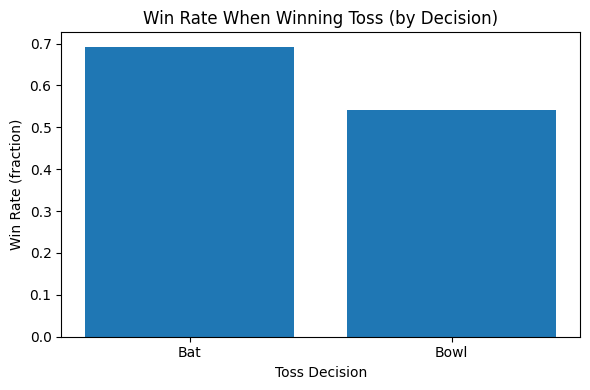

In [7]:
print("\n--- Toss impact ---")
toss_win_rate = (matches['toss_winner'] == matches['match_winner']).mean()
print(f"Toss winner also won the match: {toss_win_rate*100:.2f}% of the time")

# Toss decision effect
td = matches[['toss_decision']].copy()
td['toss_win'] = (matches['toss_winner'] == matches['match_winner']).astype(int)
td_group = td.groupby('toss_decision')['toss_win'].agg(['mean','count']).sort_values('mean', ascending=False)
print("\nWin rate by toss decision:\n", td_group)

# Plot toss decision win rate
plt.figure(figsize=(6,4))
plt.bar(td_group.index.astype(str), td_group['mean'].values)
plt.title("Win Rate When Winning Toss (by Decision)")
plt.xlabel("Toss Decision")
plt.ylabel("Win Rate (fraction)")
plt.tight_layout()
plt.show()


Top venues by chase win rate:
                                                    mean  count
venue                                                         
ACA-VDCA Cricket Stadium, Vishakhapatnam       1.000000      2
Ekana Cricket Stadium, Lucknow                 0.750000      8
Rajiv Gandhi International Stadium, Hyderabad  0.666667      6
MA Chidambaram Stadium, Chennai                0.666667      6
M. Chinnaswamy Stadium, Bangalore              0.666667      6
Wankhede Stadium, Mumbai                       0.571429      7
Sawai Mansingh Stadium, Jaipur                 0.571429      7
Arun Jaitley Stadium, Delhi                    0.571429      7
Barsapara Stadium, Guwahati                    0.500000      2
Eden Gardens, Kolkata                          0.428571      7


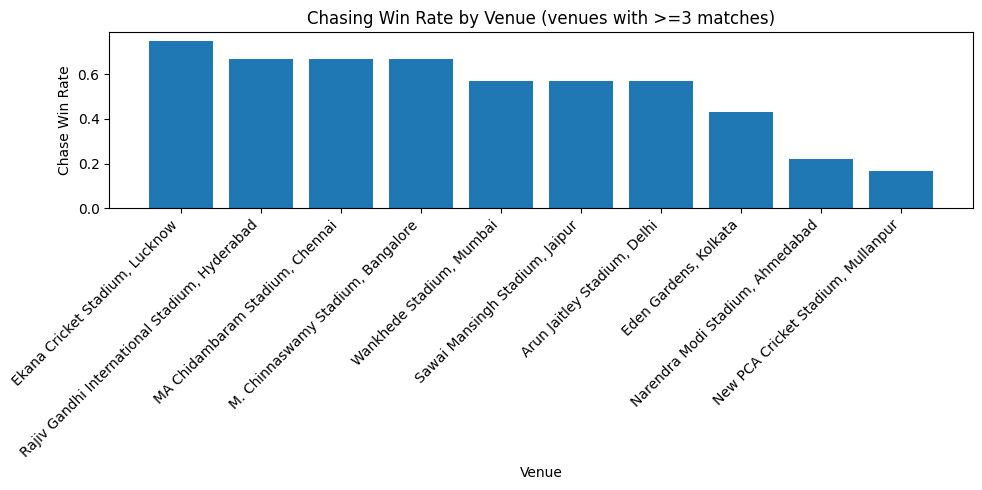


Necessity: Venue-specific tendencies (bat-first vs chase) help craft venue features for models and strategic insights.


In [8]:
m = matches.copy()
# determine who batted first: if toss_decision contains 'bat' then toss_winner batted first, else the other team
def determine_batting_first(row):
    try:
        if pd.isnull(row['toss_decision']) or pd.isnull(row['toss_winner']):
            return np.nan
        dec = str(row['toss_decision']).lower()
        if 'bat' in dec:
            return row['toss_winner']
        elif 'bowl' in dec or 'field' in dec:
            # if toss winner chose to field, the other team batted first
            return row['team1'] if row['toss_winner'] != row['team1'] else row['team2']
        else:
            return np.nan
    except Exception:
        return np.nan

m['bat_first'] = m.apply(determine_batting_first, axis=1)
m['chase_win'] = (m['match_winner'] != m['bat_first']).astype(float)
venue_chase = m.groupby('venue')['chase_win'].agg(['mean','count']).sort_values('mean', ascending=False)
print("\nTop venues by chase win rate:\n", venue_chase.head(10))

plt.figure(figsize=(10,5))
top_v = venue_chase[venue_chase['count']>=3].head(10)  # only venues with 3+ matches for stability
plt.bar(top_v.index.astype(str), top_v['mean'].values)
plt.title("Chasing Win Rate by Venue (venues with >=3 matches)")
plt.xlabel("Venue")
plt.ylabel("Chase Win Rate")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nNecessity: Venue-specific tendencies (bat-first vs chase) help craft venue features for models and strategic insights.")



--- Deliveries: runs distribution ---
Runs per delivery distribution:
 total_runs
0    5325
1    7208
2    1020
3      31
4    2269
5      33
6    1290
7       7
Name: count, dtype: int64


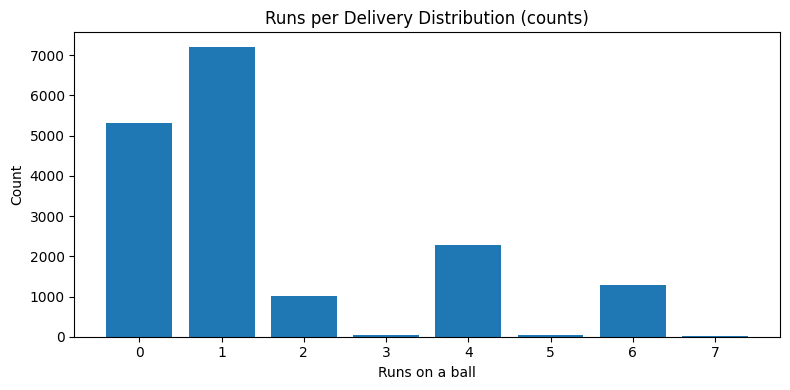


Necessity: Understanding per-ball outcomes reveals scoring patterns used for feature engineering (e.g., frequency of boundaries vs dot balls).


In [9]:
print("\n--- Deliveries: runs distribution ---")
# compute total runs per event
deliveries['extras'] = deliveries['extras'].fillna(0)
deliveries['runs_of_bat'] = deliveries['runs_of_bat'].fillna(0)
deliveries['total_runs'] = deliveries['runs_of_bat'] + deliveries['extras']

# histogram of runs per delivery (0,1,2,3,4,6 etc)
counts = deliveries['total_runs'].value_counts().sort_index()
print("Runs per delivery distribution:\n", counts.head(12))

plt.figure(figsize=(8,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Runs per Delivery Distribution (counts)")
plt.xlabel("Runs on a ball")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("\nNecessity: Understanding per-ball outcomes reveals scoring patterns used for feature engineering (e.g., frequency of boundaries vs dot balls).")



--- Boundaries & Sixes (top hitters) ---
Top boundary hitters (count of 4s+6s):
 striker
Sai Sudharsan       109
Suryakumar Yadav    107
Mitchell Marsh       93
Jaiswal              88
Prabhsimran          86
Shubman Gill         86
Kohli                85
Pooran               85
Shreyas Iyer         82
Priyansh Arya        80
Buttler              76
Abhishek Sharma      74
Name: runs_of_bat, dtype: int64


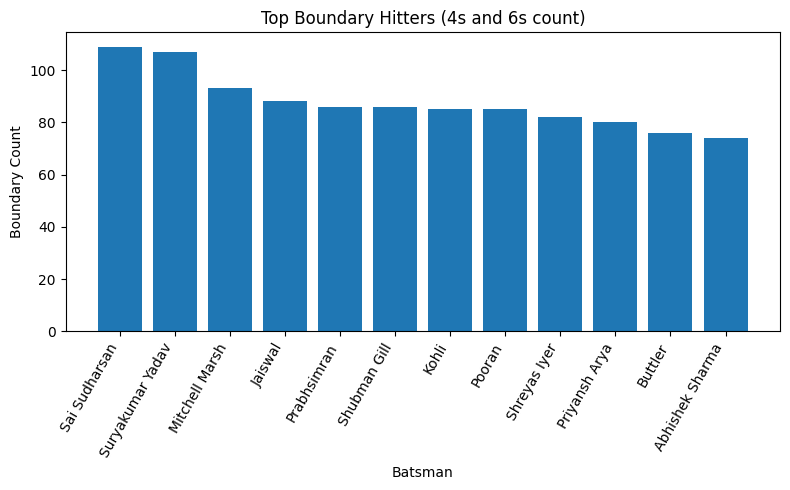

In [10]:
# 7) Boundaries & Sixes: Top hitters in dataset
print("\n--- Boundaries & Sixes (top hitters) ---")
# column name for batter may be 'striker' or 'batter'; find correct column
batter_col = None
for c in ['striker','batter','batsman','batsman_name']:
    if c in deliveries.columns:
        batter_col = c
        break

if batter_col is None:
    batter_col = 'striker'  # fallback

boundaries = deliveries[deliveries['runs_of_bat'].isin([4,6])].groupby(batter_col)['runs_of_bat'].count().sort_values(ascending=False).head(12)
print("Top boundary hitters (count of 4s+6s):\n", boundaries.head(12))

plt.figure(figsize=(8,5))
plt.bar(boundaries.index.astype(str), boundaries.values)
plt.title("Top Boundary Hitters (4s and 6s count)")
plt.xlabel("Batsman")
plt.ylabel("Boundary Count")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


--- Top bowlers by wickets & economy ---
Top wicket takers:
 bowler
Prasidh                26
Noor Ahmad             24
Boult                  23
Hazlewood              22
Arshdeep Singh         22
Bumrah                 21
Mitchell Starc         19
Sai Kishore            19
Vaibhav Arora          19
Bhuvneshwar            18
Krunal Pandya          17
Varun Chakaravarthy    17
Name: wicket_type, dtype: int64

Top bowlers by economy (min 30 balls):
 bowler
Bumrah                 6.685121
Kuldeep Yadav          7.003215
Unadkat                7.273973
Corbin Bosch           7.466667
Varun Chakaravarthy    7.597403
Santner                7.676113
Narine                 7.789091
Mustafizur             7.909091
Noor Ahmad             7.949045
Anshul Kamboj          7.984615
Riyan Parag            8.031496
Krunal Pandya          8.063830
dtype: float64


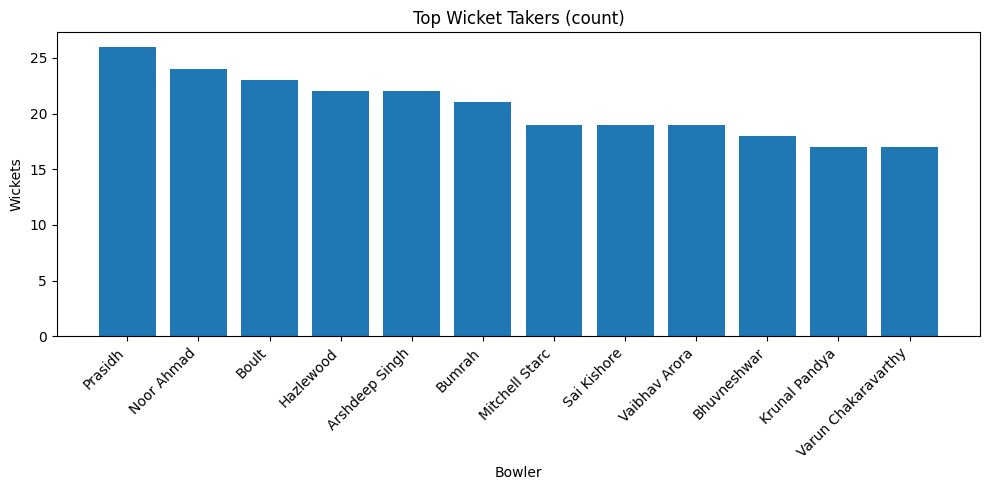

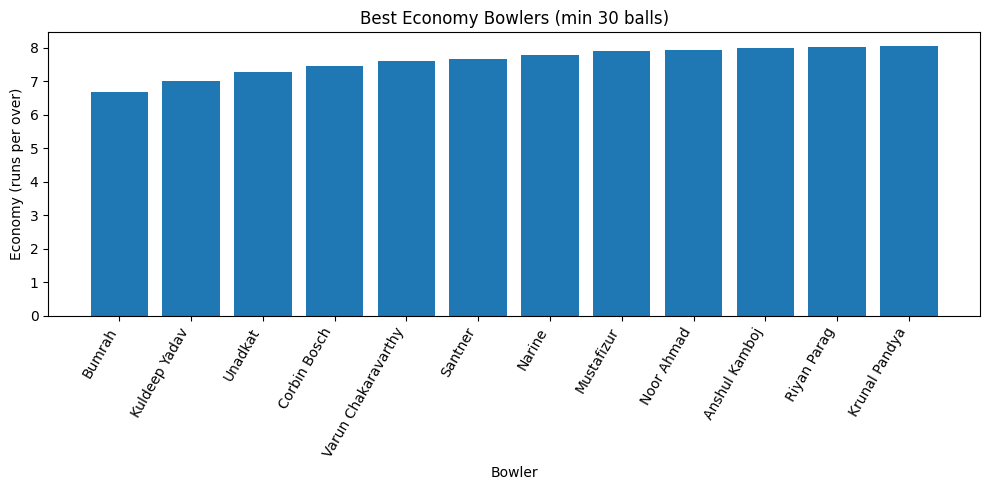


Necessity: Wickets and economy together provide a fuller picture of bowling impact for team strategy and modeling.


In [11]:
print("\n--- Top bowlers by wickets & economy ---")
# wickets: count where wicket_type not null
wicket_events = deliveries[~deliveries['wicket_type'].isnull()]
top_bowlers_wickets = wicket_events.groupby('bowler')['wicket_type'].count().sort_values(ascending=False).head(12)
print("Top wicket takers:\n", top_bowlers_wickets.head(12))

# economy: sum runs conceded / (balls/6)
bowler_runs = deliveries.groupby('bowler')['total_runs'].sum()
bowler_balls = deliveries.groupby('bowler').size()
economy = (bowler_runs / (bowler_balls/6)).sort_values()
# filter bowlers with >= 30 balls for stability
economy = economy[bowler_balls >= 30].head(12)
print("\nTop bowlers by economy (min 30 balls):\n", economy.head(12))

plt.figure(figsize=(10,5))
plt.bar(top_bowlers_wickets.index.astype(str), top_bowlers_wickets.values)
plt.title("Top Wicket Takers (count)")
plt.xlabel("Bowler")
plt.ylabel("Wickets")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(economy.index.astype(str), economy.values)
plt.title("Best Economy Bowlers (min 30 balls)")
plt.xlabel("Bowler")
plt.ylabel("Economy (runs per over)")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

print("\nNecessity: Wickets and economy together provide a fuller picture of bowling impact for team strategy and modeling.")



--- Phase-wise scoring (Powerplay / Middle / Death) ---
Powerplay top teams:
 batting_team
PBKS    1006
MI       933
RR       924
RCB      882
GT       830
LSG      783
SRH      760
DC       745
CSK      731
KKR      722
Name: total_runs, dtype: int64
Death top teams:
 batting_team
PBKS    767
MI      714
GT      705
LSG     697
CSK     683
DC      646
RCB     625
SRH     614
RR      597
KKR     482
Name: total_runs, dtype: int64


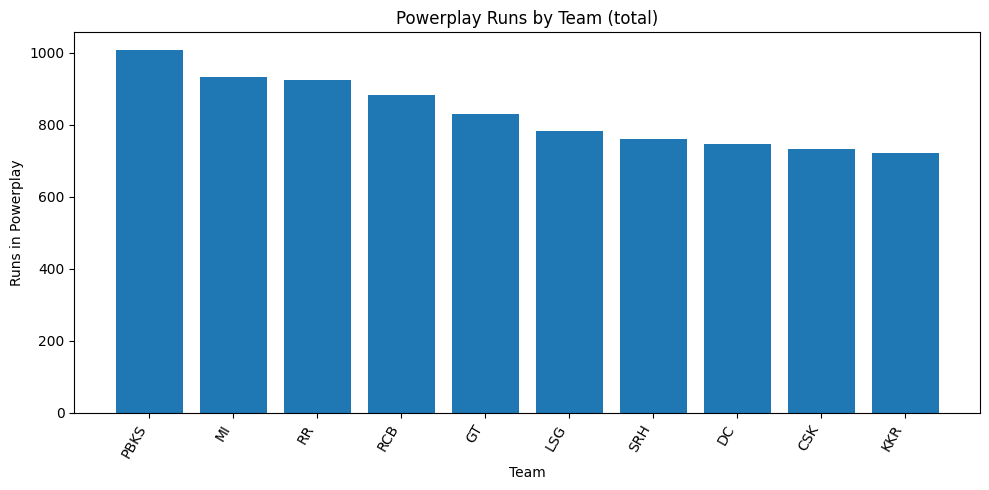

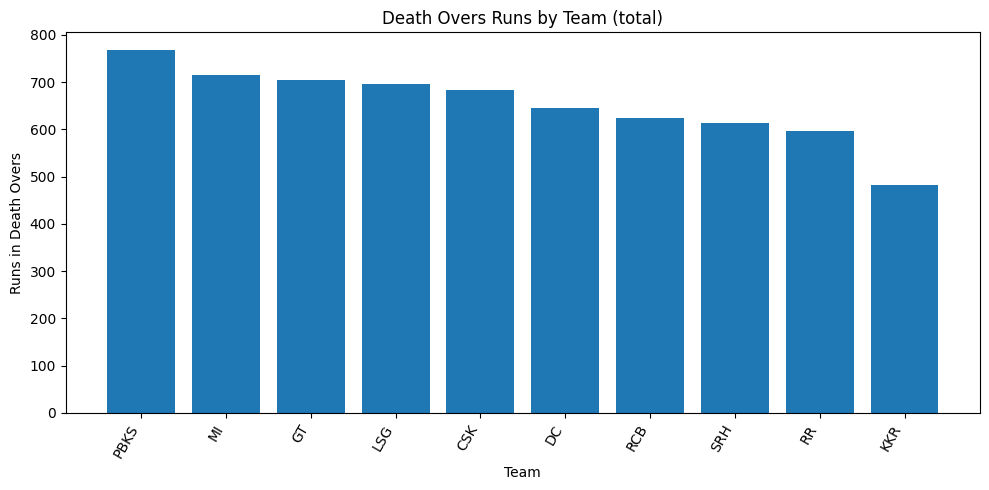


Necessity: Phase-wise performance helps quantify team strategies and can be used as input features for predictive models.


In [12]:
print("\n--- Phase-wise scoring (Powerplay / Middle / Death) ---")
# derive over integer
def get_over_num(x):
    try:
        return int(str(x).split('.')[0])
    except:
        return np.nan

deliveries['over_num'] = deliveries['over'].apply(get_over_num)

powerplay = deliveries[deliveries['over_num'] <= 5].copy()
middle = deliveries[(deliveries['over_num'] >= 6) & (deliveries['over_num'] <= 14)].copy()
death = deliveries[deliveries['over_num'] >= 15].copy()

pp_runs = powerplay.groupby('batting_team')['total_runs'].sum().sort_values(ascending=False).head(12)
mid_runs = middle.groupby('batting_team')['total_runs'].sum().sort_values(ascending=False).head(12)
death_runs = death.groupby('batting_team')['total_runs'].sum().sort_values(ascending=False).head(12)

print("Powerplay top teams:\n", pp_runs.head(10))
print("Death top teams:\n", death_runs.head(10))

plt.figure(figsize=(10,5))
plt.bar(pp_runs.index.astype(str), pp_runs.values)
plt.title("Powerplay Runs by Team (total)")
plt.xlabel("Team")
plt.ylabel("Runs in Powerplay")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(death_runs.index.astype(str), death_runs.values)
plt.title("Death Overs Runs by Team (total)")
plt.xlabel("Team")
plt.ylabel("Runs in Death Overs")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

print("\nNecessity: Phase-wise performance helps quantify team strategies and can be used as input features for predictive models.")



--- Orange & Purple Cap Highlights ---


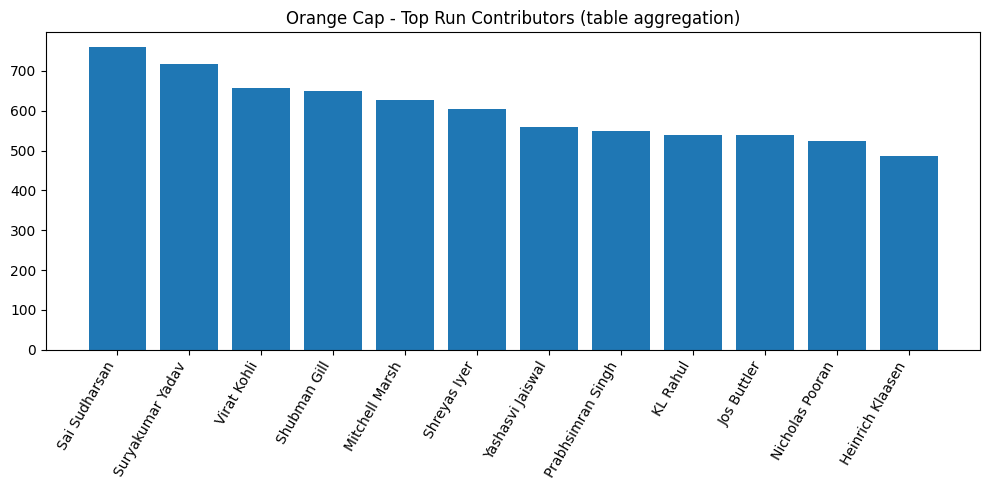

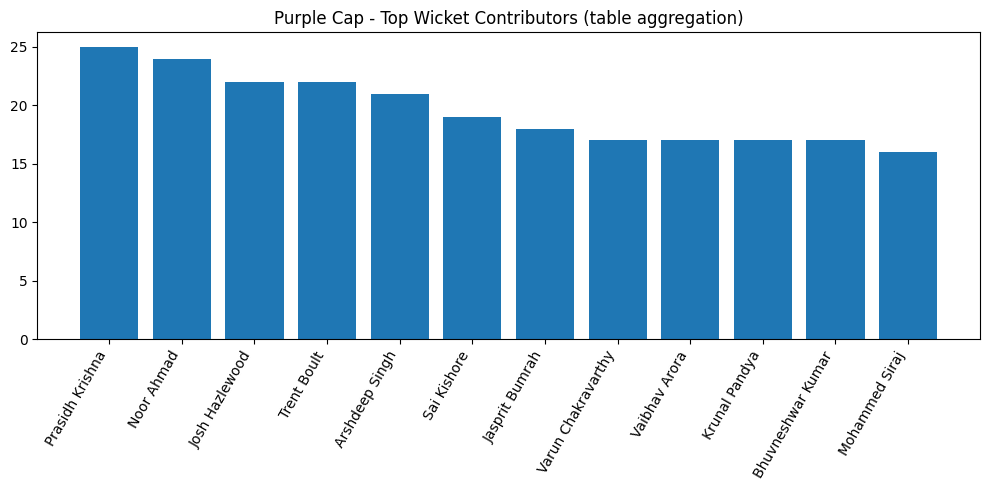


Necessity: Season-level leaderboards provide context on player impact across the tournament.


In [14]:
print("\n--- Orange & Purple Cap Highlights ---")
# display_dataframe_to_user("orange_cap_head", orange_cap.head(12))
# display_dataframe_to_user("purple_cap_head", purple_cap.head(12))

# simple bar charts from orange/purple caps
if 'Runs' in orange_cap.columns or 'runs' in orange_cap.columns:
    run_col = 'Runs' if 'Runs' in orange_cap.columns else 'runs'
    oc = orange_cap.groupby(orange_cap.columns[1])[run_col].sum().sort_values(ascending=False).head(12)
    plt.figure(figsize=(10,5))
    plt.bar(oc.index.astype(str), oc.values)
    plt.title("Orange Cap - Top Run Contributors (table aggregation)")
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()

if 'Wickets' in purple_cap.columns or 'wickets' in purple_cap.columns:
    wk_col = 'Wickets' if 'Wickets' in purple_cap.columns else 'wickets'
    pc = purple_cap.groupby(purple_cap.columns[1])[wk_col].sum().sort_values(ascending=False).head(12)
    plt.figure(figsize=(10,5))
    plt.bar(pc.index.astype(str), pc.values)
    plt.title("Purple Cap - Top Wicket Contributors (table aggregation)")
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()

print("\nNecessity: Season-level leaderboards provide context on player impact across the tournament.")


In [16]:
print("\n--- 2025 Season Snapshot ---")
# display_dataframe_to_user("matches_2025_head2", matches_2025.head())

# Basic stats for 2025 first and second innings scores if present
for col in ['first_ings_score','second_ings_score','win_by_runs','win_by_wickets','match_winner']:
    if col in matches_2025.columns:
        print(f"{col} in 2025 - non-null count:", matches_2025[col].notnull().sum())

if 'first_ings_score' in matches_2025.columns:
    plt.figure(figsize=(8,4))
    plt.hist(matches_2025['first_ings_score'].dropna(), bins=12)
    plt.title("Distribution of First Innings Scores (2025)")
    plt.xlabel("First Innings Score")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

print("\nNecessity: Season-specific snapshot helps pick out emerging patterns for the current year and compare with aggregate history.")



--- 2025 Season Snapshot ---
win_by_runs in 2025 - non-null count: 33
win_by_wickets in 2025 - non-null count: 37
match_winner in 2025 - non-null count: 74

Necessity: Season-specific snapshot helps pick out emerging patterns for the current year and compare with aggregate history.



--- Correlation Matrix (match-level numeric cols) ---
Numeric columns considered: ['match_id', 'first_ings_score', 'first_ings_wkts', 'second_ings_score', 'second_ings_wkts', 'balls_left', 'highscore']


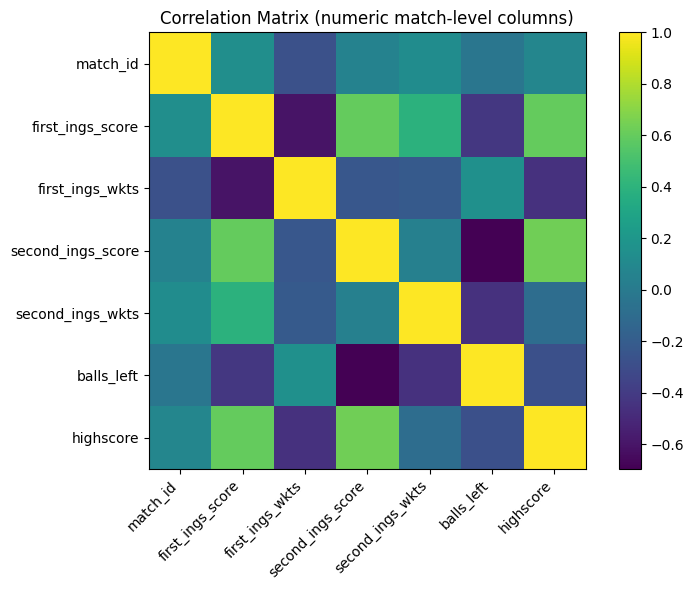

In [17]:
print("\n--- Correlation Matrix (match-level numeric cols) ---")
numeric_cols = matches.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    corr = matches[numeric_cols].corr().fillna(0)
    print("Numeric columns considered:", numeric_cols)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, interpolation='nearest')
    plt.colorbar(im)
    plt.title("Correlation Matrix (numeric match-level columns)")
    # ticks
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.tight_layout()
    plt.show()
else:
    print("No numeric match-level columns available for correlation matrix.")

In [4]:
teams_df = pd.read_csv("teams_data.csv")
players_df = pd.read_csv("players-data-updated.csv")
matches_df = pd.read_csv("ipl_2025_matches_data.csv")

In [5]:
team_mapping = dict(zip(teams_df['team_id'], teams_df['team_name']))

# Replace team_id columns with team_name
matches_df['team1'] = matches_df['team1'].map(team_mapping)
matches_df['team2'] = matches_df['team2'].map(team_mapping)
matches_df['toss_winner'] = matches_df['toss_winner'].map(team_mapping)
matches_df['match_winner'] = matches_df['match_winner'].map(team_mapping)

print(matches_df[['team1', 'team2', 'toss_winner', 'match_winner']].head())

                   team1                        team2  \
0  Kolkata Knight Riders  Royal Challengers Bangalore   
1    Sunrisers Hyderabad             Rajasthan Royals   
2         Mumbai Indians          Chennai Super Kings   
3   Lucknow Super Giants               Delhi Capitals   
4           Punjab Kings               Gujarat Titans   

                   toss_winner                 match_winner  
0  Royal Challengers Bangalore  Royal Challengers Bangalore  
1             Rajasthan Royals          Sunrisers Hyderabad  
2          Chennai Super Kings          Chennai Super Kings  
3               Delhi Capitals               Delhi Capitals  
4               Gujarat Titans                 Punjab Kings  


In [6]:
features = ['team1', 'team2', 'toss_winner', 'toss_decision', 'venue']
target = 'match_winner'

data = matches_df[features + [target]].dropna()

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode all categorical columns
encoders = {}
for col in features + [target]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

print(data.head())

   team1  team2  toss_winner  toss_decision  venue  match_winner
0      3      8            8              1      4             8
1      9      7            7              1     11             9
2      5      0            0              1      7             0
3      4      1            1              1      3             1
4      6      2            2              1     10             6


In [19]:
from sklearn.model_selection import train_test_split

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)


Accuracy: 0.5333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         1
           5       0.67      1.00      0.80         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.67      1.00      0.80         2
           9       0.00      0.00      0.00         2

    accuracy                           0.53        15
   macro avg       0.43      0.55      0.48        15
weighted avg       0.41      0.53      0.46        15



C:\Users\hitar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hitar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hitar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

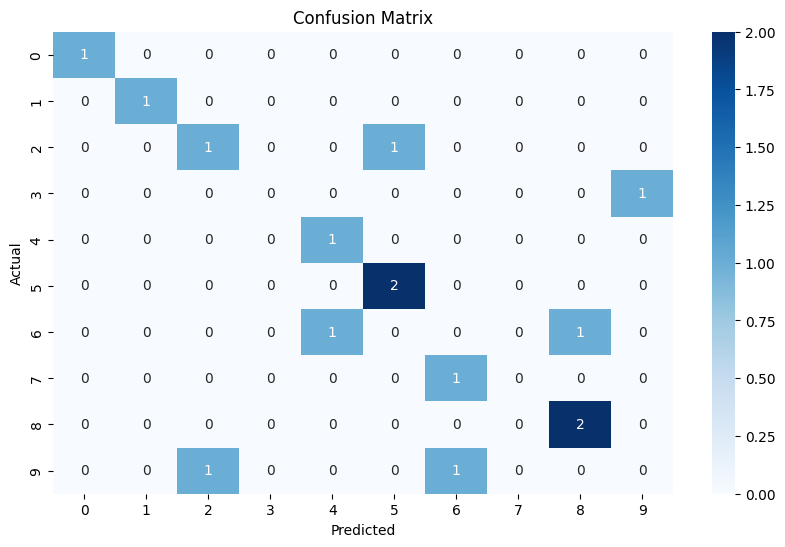

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [30]:
# Convert numeric predictions back to team names
team_winner_encoder = encoders[target]

y_pred_team = team_winner_encoder.inverse_transform(y_pred)
y_test_team = team_winner_encoder.inverse_transform(y_test)

# Example output
results_df = pd.DataFrame({
    "Team1": encoders['team1'].inverse_transform(X_test['team1']),
    "Team2": encoders['team2'].inverse_transform(X_test['team2']),
    "Predicted Winner": y_pred_team,
    "Actual Winner": y_test_team
})

print(results_df.head(10))


                         Team1                        Team2  \
0             Rajasthan Royals                 Punjab Kings   
1         Lucknow Super Giants               Delhi Capitals   
2               Mumbai Indians               Gujarat Titans   
3          Sunrisers Hyderabad               Mumbai Indians   
4             Rajasthan Royals  Royal Challengers Bangalore   
5  Royal Challengers Bangalore          Chennai Super Kings   
6         Lucknow Super Giants               Mumbai Indians   
7  Royal Challengers Bangalore                 Punjab Kings   
8          Chennai Super Kings               Mumbai Indians   
9                 Punjab Kings         Lucknow Super Giants   

              Predicted Winner                Actual Winner  
0                 Punjab Kings             Rajasthan Royals  
1               Delhi Capitals               Delhi Capitals  
2               Mumbai Indians               Gujarat Titans  
3               Mumbai Indians               Mumbai Indian